# GRU Sentiment Classifier

In this notebook, we use a GRU to classify IMDB movie reviews by their sentiment.

### Load dependencies

In [1]:
import tensorflow
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, SpatialDropout1D
from tensorflow.keras.layers import GRU # new! 
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 

### Set hyperparameters

In [2]:
# output directory name:
output_dir = 'model_output/gru'

# training:
epochs = 20
batch_size = 128

# vector-space embedding: 
n_dim = 64 
n_unique_words = 10000 
max_review_length = 100 # lowered due to vanishing gradient over time
pad_type = trunc_type = 'pre'
drop_embed = 0.2 

# GRU layer architecture:
n_gru = 256 
drop_gru = 0.2

# dense layer architecture: 
n_dense = 256
dropout = 0.2

### Load data

In [3]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words) # removed n_words_to_skip

17464789/17464789 [==============================] - 2s 0us/step


### Preprocess data

In [4]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

### Design neural network architecture

In [5]:
model = Sequential()

# first hidden layer:
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length)) 
model.add(SpatialDropout1D(drop_embed))

# Second hidden layer:
model.add(GRU(n_gru, dropout=drop_gru))

# Third hidden layer:
model.add(Dense(n_dense, activation='relu')) # typically don't see top dense layer in NLP like in 
model.add(Dropout(dropout))

# Output layer:
model.add(Dense(1, activation='sigmoid'))

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           640000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 100, 64)          0         
 ropout1D)                                                       
                                                                 
 gru (GRU)                   (None, 256)               247296    
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                        

### Configure model

In [7]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [8]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

### Train!

In [9]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Epoch 1/20
196/196 [==============================] - 12s 23ms/step - loss: 0.5929 - accuracy: 0.6680 - val_loss: 0.4938 - val_accuracy: 0.7625
Epoch 2/20
196/196 [==============================] - 4s 19ms/step - loss: 0.3460 - accuracy: 0.8497 - val_loss: 0.3636 - val_accuracy: 0.8472
Epoch 3/20
196/196 [==============================] - 4s 21ms/step - loss: 0.2660 - accuracy: 0.8914 - val_loss: 0.3428 - val_accuracy: 0.8509
Epoch 4/20
196/196 [==============================] - 4s 21ms/step - loss: 0.2217 - accuracy: 0.9132 - val_loss: 0.3842 - val_accuracy: 0.8355
Epoch 5/20
196/196 [==============================] - 4s 19ms/step - loss: 0.1792 - accuracy: 0.9326 - val_loss: 0.3663 - val_accuracy: 0.8487
Epoch 6/20
196/196 [==============================] - 4s 19ms/step - loss: 0.1480 - accuracy: 0.9446 - val_loss: 0.4104 - val_accuracy: 0.8442
Epoch 7/20
196/196 [==============================] - 4s 20ms/step - loss: 0.1193 - accuracy: 0.9574 - val_loss: 0.5254 - val_accuracy: 0.836

### Evaluate

In [10]:
model.load_weights(output_dir+"/weights.03.hdf5") 

In [12]:
y_hat = model.predict(x_valid)

782/782 [==============================] - 3s 4ms/step


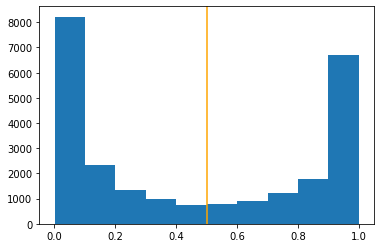

In [13]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [14]:
"{:0.2f}".format(roc_auc_score(y_valid, y_hat)*100.0)

'93.24'